* Παναγιώτης Ζευγολατάκος 03117804
* Χατζηθεοδώρου Ιάσων 03117089
* Ανδρέας Βεζάκης 03117186

# Εφαρμογή 2

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.cluster import KMeans
from tabulate import tabulate
from gensim.models import Word2Vec
import gensim.downloader
from gensim.parsing.preprocessing import remove_stopwords, strip_non_alphanum, strip_short
import somoclu
import matplotlib
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer, LancasterStemmer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
%matplotlib inline

import joblib
import random
import string
from copy import deepcopy
import re
import multiprocessing

## Δημιουργία dataset

In [ ]:
my_best_corpus = w2v

In [ ]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
final_set = build_final_set(my_best_corpus)

final_set.shape

(5000, 372)

## Εκπαίδευση χάρτη SOM

In [ ]:
som = somoclu.Somoclu(30, 30)

In [ ]:
som.train(final_set, epochs=100)

## Best matching units

In [ ]:
bmus, indices = np.unique(som.bmus, axis=0, return_index=True)

## Ομαδοποίηση

In [ ]:
som.cluster(KMeans(n_clusters=30))

## Αποθήκευση του SOM

In [ ]:
joblib.dump(som, 'som_w2v')

['som_w2v']

## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

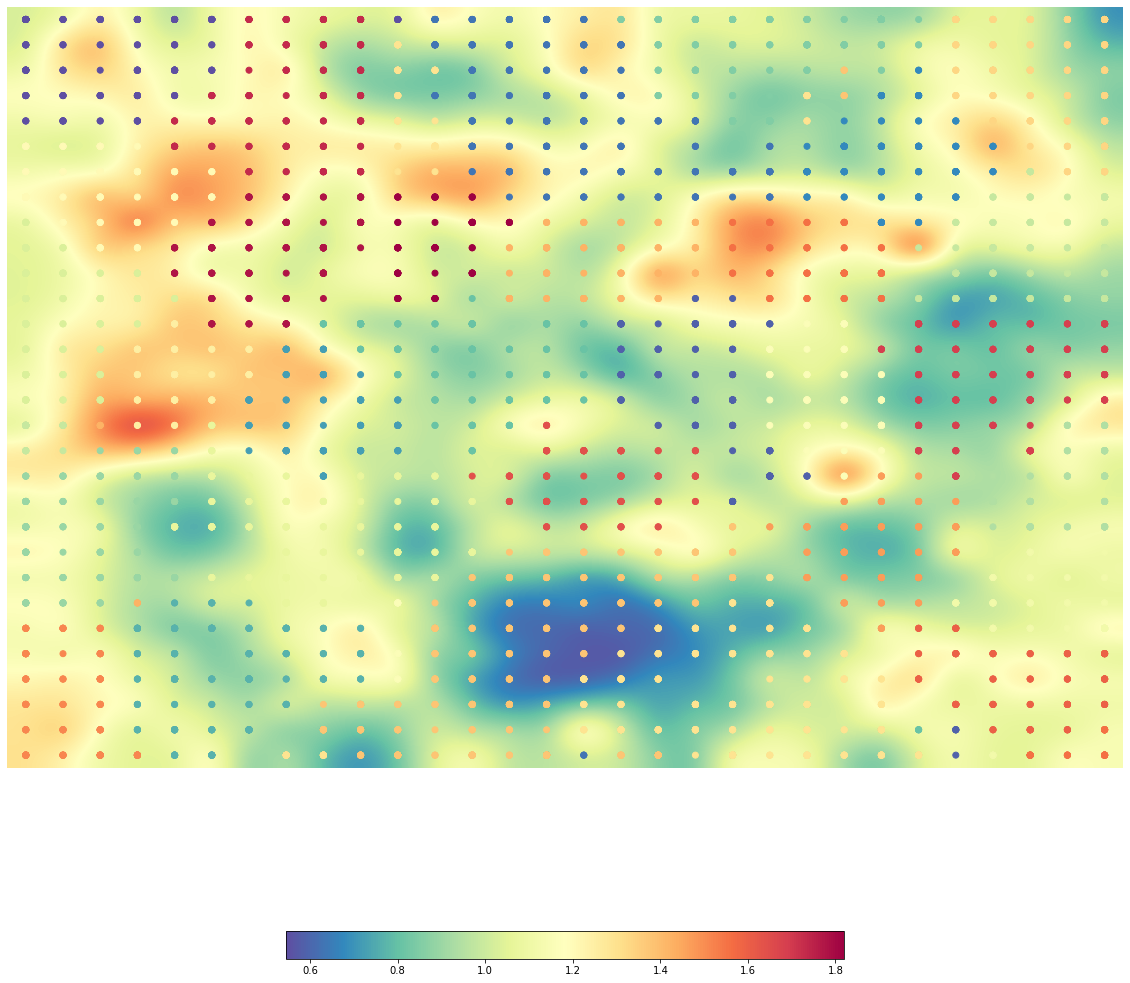

In [ ]:
som.view_umatrix(bestmatches=True, colorbar=True,figsize=(20, 20))
plt.show()

In [ ]:
som.clusters

array([[ 0,  0,  0,  0,  0,  0, 27, 27, 27, 27,  0,  2,  2,  2,  2,  2,
         7,  7,  7,  7,  7,  7,  7,  7,  7, 18, 18, 18, 18, 18],
       [ 0,  0,  0,  0,  0,  0, 27, 27, 27, 27, 17,  2,  2,  2,  2,  2,
         2,  7,  7,  7,  7,  7,  7,  7,  7, 18, 18, 18, 18, 18],
       [ 0,  0,  0,  0,  0,  0, 27, 27, 27, 27, 17, 17,  2,  2,  2,  2,
         2,  7,  7,  7,  7,  7, 19,  7,  3, 18, 18, 18, 18, 18],
       [ 0,  0,  0,  0,  0, 27, 27, 27, 27, 27, 17,  2,  2,  2,  2,  2,
         2,  7,  7,  7,  7, 17, 19,  3,  3, 18, 18, 18, 18, 18],
       [ 0,  0,  0,  0, 27, 27, 27, 27, 27, 27, 17, 17,  2,  2,  2,  2,
         2,  2,  2,  7,  7, 17,  3,  3,  3,  3, 18, 18, 18, 18],
       [15, 15, 15, 15, 27, 27, 27, 27, 27, 27, 17, 17,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3, 18, 18, 18],
       [15, 15, 15, 15, 15, 15, 27, 27, 27, 27, 17, 17,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3, 10, 18, 18],
       [15, 15, 15, 15, 15, 15, 28, 28, 2

In [ ]:
values, counts = np.unique(som.clusters, return_counts=True)
sorted_counts = np.argsort(counts)

table = zip(list(values[sorted_counts]), list(counts[sorted_counts]))
print(tabulate(table, headers=["Cluster index", "No. of neurons"]))

  Cluster index    No. of neurons
---------------  ----------------
             16                14
             29                15
              9                16
             13                18
             22                19
              4                21
             24                22
             23                22
             15                22
             20                24
             11                25
             14                25
              3                26
             25                26
             21                27
              0                28
             28                28
              7                29
             18                29
              8                30
             10                32
              1                32
             27                33
              6                34
             26                35
              5                37
             12                44
              

## Σημασιολογική ερμηνεία των clusters

In [ ]:
def print_categories_stats(movie_ids, print_table=False):
    categories_found = []
    table = []
    for id in movie_ids:
        categories_found.extend([c.strip('," ') for c in categories[id][0].split()])

    values, counts = np.unique(categories_found, return_counts=True)
    sorted_counts = np.argsort(counts)
    table = zip(list(values[sorted_counts]), list(counts[sorted_counts]))
    
    if print_table:
        print(tabulate(table, headers=["Category", "Frequency"]))
    else:
        print(list(table))

In [ ]:
print_categories_stats([10, 1114, 2345], True)

Category           Frequency
---------------  -----------
Black-and-white            1
movie                      1
comedy                     1
Thriller                   1
Television                 1
Short                      1
Science                    1
Romantic                   1
Romance                    1
Psychological              1
Mystery                    1
Indie                      1
Horror                     1
Fiction                    1
Drama                      1
Comedy-drama               1
Comedy                     1
noir                       1
thriller                   1
Film                       3


In [ ]:
def print_cluster_neurons_movies_report(cluster_id):
    cluster_bmus = np.column_stack(np.where(som.clusters == cluster_id)[::-1])
    index_list = [indices[np.where(np.all(bmus == bmu, axis=1))[0]] for bmu in cluster_bmus if bmu in bmus]

    return [index[0] for index in index_list if len(index) > 0]

In [ ]:
print_cluster_neurons_movies_report(2)

[960,
 577,
 2943,
 797,
 2105,
 758,
 244,
 846,
 1228,
 2744,
 983,
 405,
 55,
 2019,
 678,
 267,
 774,
 711,
 868,
 189,
 116,
 573,
 2710,
 924,
 149,
 335,
 978,
 351,
 730,
 675,
 2631,
 1090,
 372,
 1756,
 233,
 2131,
 1454,
 915,
 1139,
 640,
 339,
 780,
 539,
 73,
 120,
 4286,
 2471,
 1134,
 1580,
 364,
 321,
 3231,
 635,
 302]

In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [ ]:
def neuron_movies_report(neuron_ids):
    movie_ids = [np.where(np.all(som.bmus == neuron_id, axis=1))[0] for neuron_id in neuron_ids]
    movie_ids = [list(m) for m in movie_ids]

    return flatten(movie_ids)

In [ ]:
len(neuron_movies_report([0,1]))
# print(neuron_movies_report([0, 1]))

27

In [ ]:
cluster = 0
cluster_neurons = print_cluster_neurons_movies_report(cluster)
id_list = neuron_movies_report(cluster_neurons)
x = print_categories_stats(id_list, print_table=True)

Category             Frequency
-----------------  -----------
Action/Adventure             1
Tamil                        1
Romantic                     1
Romance                      1
Picture                      1
Family-Oriented              1
drama                        1
Comedy                       1
Children's/Family            1
Bollywood                    1
Animal                       1
Family                       2
Adventure                    2
Drama                        2
Short                        3
World                        3
cinema                       4
Musical                      4
Film                         6


In [ ]:
cluster = 3
cluster_neurons = print_cluster_neurons_movies_report(cluster)
id_list = neuron_movies_report(cluster_neurons)
x = print_categories_stats(id_list, print_table=True)

Category           Frequency
---------------  -----------
Black-and-white            1
Comedy-drama               1
Ensemble                   1
Family                     1
Thriller                   1
comedy                     1
Comedy                     4
Bollywood                 24
Musical                   24
Romance                   24
World                     24
cinema                    24
drama                     24
Drama                     25
Film                      25
Romantic                  25


In [ ]:
cluster = 25
cluster_neurons = print_cluster_neurons_movies_report(cluster)
id_list = neuron_movies_report(cluster_neurons)
x = print_categories_stats(id_list, print_table=True)

Category           Frequency
---------------  -----------
Black-and-white            1
Bollywood                  1
Romantic                  10
comedy                    10


In [ ]:
cluster = 11
cluster_neurons = print_cluster_neurons_movies_report(cluster)
id_list = neuron_movies_report(cluster_neurons)
x = print_categories_stats(id_list, print_table=True)

Category             Frequency
-----------------  -----------
&                            1
noir                         1
film                         1
Society                      1
Short                        1
Science                      1
Picture                      1
Period                       1
Mythological                 1
Mystery                      1
Heaven-Can-Wait              1
Fantasies                    1
Epic                         1
Dance                        1
piece                        1
Crime                        1
Animal                       1
Culture                      1
Christian                    1
Fiction                      2
Sports                       2
Action                       2
Rockumentary                 2
drama                        2
Japanese                     2
Movies                       2
Anime                        2
Costume                      2
Animated                     3
Comedy                       3
Music   

In [ ]:
cluster = 12
cluster_neurons = print_cluster_neurons_movies_report(cluster)
id_list = neuron_movies_report(cluster_neurons)
x = print_categories_stats(id_list, print_table=True)

Category             Frequency
-----------------  -----------
Adventure                    1
Blaxploitation               1
Children's                   1
Entertainment                1
Family-Oriented              1
History                      1
Mystery                      1
Romance                      1
Spaghetti                    1
Animated                     2
Children's/Family            2
Short                        2
cartoon                      2
Animation                    3
Film                         3
Western                      5


## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Από τα παραπάνω αποτελέσματα, παρατηρούμε ότι:
1. Όπως περιμέναμε, οι πιο συχνές κατηγορίες συσχετίζονται με μεγάλο αριρθμό νευρώνων.
2. Τα clusters 3 και 17 τα οποία είναι απομακρυσμένα στον χάρτη, χαρακτηρίζονται από διαφορετικές κατηγορίες (Romadic, Κωμωδία).
3. Τα γειτονικά clusters έχουν κλίση προς τις ίδιες κατηγορίες. (Το 0 και το 3 αποτελούνται κυρίως από Drama)
4. Ενδιαφέρον έχει το cluster 11 το οποία αντιπροσωπεύει την κατηγορία "Adventure", το οποίο δεν συνδέεται έμμεσα με τη γειτονιά του. Αυτό θεωρούμε πως οφείλεται στο ότι το "adventure" συνδέεται με τις υπόλοιπες κατηγορίες κατηγορίες, αφού η μία μπορεί να είναι υποσύνολο της άλλης. 